# Motivation

Don Bradman is almost universally considered the greatest batsman of all time, with his Test average being 99.94. He is quite the outlier, as is visible in charts like this:

<div style="text-align: center;">
    <img src="images/bradman_histogram.jpeg" width=500>
</div>

However, he does not have the highest Test average of all time. That honour belongs to Kurtis Patterson with an average of 144, after playing two innings, in which he got 30 and 114*, and never playing another Test match. So here's what the chart looks like if you don't universally apply the minimum of 25 innings and 1000 runs, and include Patterson too: 

<div style="text-align: center;">
    <img src="images/histogram_plus_patterson.png" width=800>
</div>

Still, one can pretty safely assume that the Don is a better batsman, given his performance was sustained over two decades rather than just two innings. But how good is Patterson? Here I try to answer that question just looking at his two Test innings, without considering other (very useful) information about his first-class career, or other facts about the innings that he played (e.g., the strength of the bowlers he was against, or that in his second innings he was one of three Australians who scored centuries). I omit this more useful information because:
* I find it a more interesting question to see how information we can get from these two outings alone; and
* This approach is more generalisable, e.g., answering how to evaluate a batter with very few outings.

I adopt a Bayesian approach, wherein I start with a prior for what one should expect Patterson's skill to be, and then update that by conditionalising on his two Test scores. 

# Setting up the notebook and importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import warnings

warnings.filterwarnings("ignore")

print("Finished importing packages")

Finished importing packages


In [5]:
os.listdir()

['.DS_Store',
 'pad.txt',
 'images',
 'test_data',
 'plan.txt',
 'patterson.ipynb',
 '.ipynb_checkpoints',
 'prelim_looking.ipynb',
 'test_data.zip']

In [10]:
outs = {}
not_outs = {}

# Unzipped folder is 200mb, zipped is 10mb
# So I keep it as a zip; this code unzips, reads, then deletes the folder
# Leaving only the zip
with zipfile.ZipFile("test_data.zip", 'r') as zip_ref:
    zip_ref.extractall("test_data")

csvs = [i for i in os.listdir("test_data/test_data") if "info" not in i and "README" not in i]
for csv in csvs:
    df = pd.read_csv("test_data/test_data/" + csv)
    for i in df.innings.unique():
        trim = df[df.innings == i].copy()
        runs = trim.groupby("striker")["runs_off_bat"].sum()
        out = trim.groupby("striker")["player_dismissed"].count()
        for batter in runs.index:
            innings_total = runs.loc[batter]
            if out.loc[batter] == 1:
                if batter in outs:
                    outs[batter].append(innings_total)
                else:
                    outs[batter] = [innings_total]
            else:
                if batter in not_outs:
                    not_outs[batter].append(innings_total)
                else:
                    not_outs[batter] = [innings_total]

batter_names = list(set(list(outs.keys()) + list(not_outs.keys())))
for key in outs.keys():
    if key not in not_outs.keys():
        not_outs[key] = []
for key in not_outs.keys():
    if key not in outs.keys():
        outs[key] = []

shutil.rmtree("test_data")

print("Finished importing data")

Finished importing data


In [11]:
# Handy lookup function: put in part of a name and you get all names that contain that part
component = "Broad"
for name in batter_names:
    if component in name:
        print(name)

SCJ Broad


# A method for evaluating batters' skill

To update on a given score, we need to know what a batter's chance is of getting to that score, given a certain skill level. To start, let's have a look at some batters in the dataset and look at their chances of surviving to a given score. 

Not-outs need to be handled separately to cases where a batter got out. That is because a batter finishing their innings not-out is a kind of censoring of data: if a batter would have got 200 but their team declared or they won when they were on 5 runs, all that gets recorded on the scorecard is that they got 5*. 

For this I use a Kaplan-Meier estimator. To calculate the probability that a batter survives from 10 runs to 11 runs, I count up the number of times that they got out on 10 and divide that by the number of times they get out on 10 plus the number of times they make it to 11. So if a batter has a 50*, then that not-out score has the effect of increasing their survival probabilities for every run under 50, but does nothing for 50 and above. However, if they have a 50 where they got out, that score has the effect of increasing their survival probabilities for every run under 50, increases their probability of getting to 50 but not making it to 51, and has no effect on anything beyond 51. (For cases where a batter's top score is a not-out, that is treated as them getting out because otherwise the data gets messy. Sorry David Warner - I know you would have got 500 against Pakistan.)

Here are the observed survival curves for a number of batters:

In [12]:
def get_survival_odds(batter):
    out_series = pd.Series(outs[batter])
    no_series = pd.Series(not_outs[batter])
    all_scores = pd.concat([out_series, no_series])
    xticks = pd.Series(np.arange(0, all_scores.max()))
    yticks = pd.Series(
        [(out_series == xtick).sum() / (all_scores >= xtick).sum()
         for xtick in xticks]
    )
    return pd.concat([(1 - yticks).cumprod(), pd.Series(0, index=[len(xticks)])])

def graph_survival_odds(batters):
    graph_frame = pd.DataFrame({batter: get_survival_odds(batter) for batter in batters})
    fig, ax = plt.subplots()
    ax.plot(graph_frame)
    ax.legend(batters)
    plt.show()

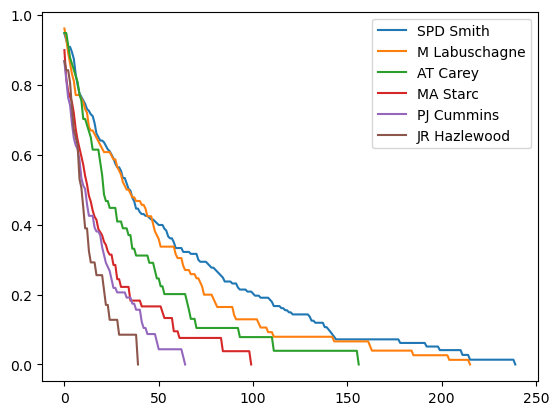

In [13]:
batters = ["SPD Smith", "M Labuschagne", "AT Carey", "MA Starc", "PJ Cummins", "JR Hazlewood"]
graph_survival_odds(batters)

A useful thing to look at here is the hazard function, which gives you a given batter's observed probability of getting out on a given score. By looking at this, hopefully you can see if there are any scores that are particularly dangerous for a batter to be on. Here is Steve Smith's, with the red line denoting a smoothed average over the nearest totals:

In [14]:
def get_hazard(batter):
    out_series = pd.Series(outs[batter])
    no_series = pd.Series(not_outs[batter])
    all_scores = pd.concat([out_series, no_series])
    xticks = pd.Series(np.arange(0, all_scores.max()))
    yticks = pd.Series(
        [(out_series == xtick).sum() / (all_scores >= xtick).sum()
         for xtick in xticks]
    )
    return pd.concat([yticks, pd.Series(1, index=[len(xticks)])])

def graph_hazard(batters):
    averaged = sum([get_hazard(name) for name in batters]) / len(batters)
    fig, ax = plt.subplots()
    ax.plot(averaged, color="black")
    xticks = pd.Series(averaged.index)
    yticks = [averaged[abs(averaged.index - xtick) < 5].mean() for xtick in xticks]
    # ax.plot(xticks, yticks, color="red")
    plt.show()

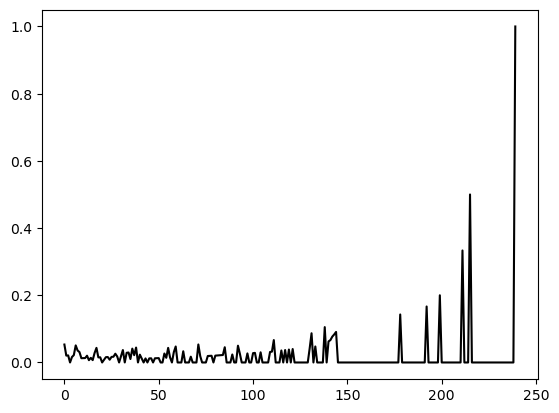

In [15]:
graph_hazard(["SPD Smith"])

Unfortunately that is very noisy for the higher numbers, and it is hard to see any patterns just yet. To de-noise this data, we can reduce variance by including more than one batter in the sample. This won't be useful if all the batters are of significantly different skill, so I will group them according to how much area is under their survival curve, which is effectively their batting average (it differs slightly, but I will get to that later). 

In [16]:
def get_area_under_curve(batter):
    odds = get_survival_odds(batter)
    return ((odds.shift(1) - odds) * odds.index).dropna().sum()

batter_areas = pd.Series(
    [get_area_under_curve(batter) for batter in batter_names],
    index=batter_names
)

['N Hussain', 'SR Tendulkar', 'TWM Latham', 'DS Lehmann', 'SR Waugh', 'DP Conway', 'IR Bell', 'Imam-ul-Haq', 'FDM Karunaratne', 'MR Ramprakash', 'V Kohli', 'RG Sharma', 'LRPL Taylor', 'Nasir Hossain', 'L Ronchi', 'BKG Mendis', 'DE Bernard', 'WPUJC Vaas', 'KP Pietersen', 'SM Katich', 'JL Smith', 'LPC Silva', 'SM Warnapura', 'AC Agar', 'RR Sarwan', 'RD Rickelton', 'BJ Watling', 'A Flintoff', 'ME Trescothick', 'MA Butcher', 'OJ Pope', "KJ O'Brien", 'WJ Pucovski', 'JM Bairstow', 'DAS Gunaratne', 'D Mohammed', 'Shakib Al Hasan', 'CH Gayle', 'JDP Oram', 'BM Duckett', 'VVS Laxman', 'MS Dhoni', 'CR Ervine', 'AM Rahane', 'Umar Akmal', 'C Green', 'I Kaia', 'AG Prince', 'CR Brathwaite', 'F du Plessis', 'JA Burns', 'JD Ryder', 'DL Vettori', 'Manjural Islam Rana', 'BA Stokes', 'KC Sangakkara', 'TM Dilshan', 'Zulqarnain Haider', 'JA Morkel', 'SN Khan']


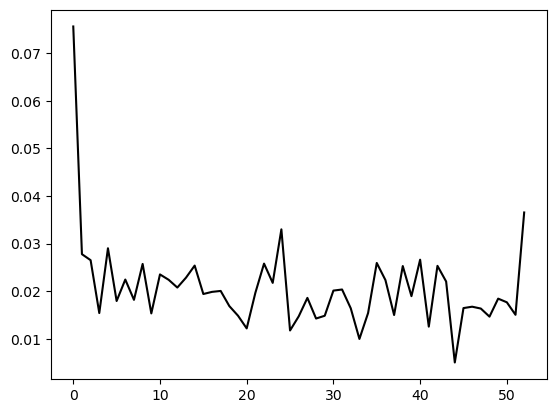

In [17]:
# This samples the top batters, but you can change the range in
# the iloc brackets to get batters of different skill levels. 
# The numbers on the y-axis change, but the shape of the graph does not. 
names = batter_areas.sort_values().iloc[800:1000].sample(frac=0.3).index.to_list()
print(names)
graph_hazard(names)

There is a robust pattern which appears whenever the above cell is run, which is that there is a significantly higher risk of getting out on 0, and then the hazard decays as they get more runs. (There is usually a spike at the end, because the chart ends at the lowest N for which any of the batters have not scored N, so there is a selection effect which makes noise in that part of the graph look like a signal.) This is a well-known effect of batters "getting their eye in", or being harder to get out the longer they have been in. Seen another way: batters' skill varies from day to day, and a batter having scored a number of runs is good evidence that they are having a good day, which means that they are harder to get out. 

Fitting a hazard function by eye, I settled on there being a baseline hazard, and additional amount of hazard that decays exponentially the longer the batter stays in (with half-life of 25 runs) half the size of the baseline, and a special extra amount of hazard for when the batter is on 0, which means they have a 4 * baseline probability of getting a duck. 

The baseline for a given batter is calculated by minimising the squared error between the survival curve generated by the hazard function for a given baseline and the batter's empirical survival curve, as in the following cases:

In [18]:
def get_hazard_given_baseline(baseline):
    bat = pd.Series(np.arange(10000))
    return baseline * (1 + (bat.index == 0) * 2.5 + 2 ** (-pd.Series(bat.index) / 25) * 1 / 2)

def get_baseline(batter):
    bat = get_survival_odds(batter)
    rows = []
    for baseline in np.arange(0, 0.1, 0.001): # can change, but at 0.0001 it gets a bit slow
        hazard = get_hazard_given_baseline(baseline)
        int_hazard = (1 - hazard).cumprod()
        sq_err = ((int_hazard - bat) ** 2).sum()
        rows.append([baseline, sq_err])
    return pd.DataFrame(rows, columns=["baseline", "sq_err"])

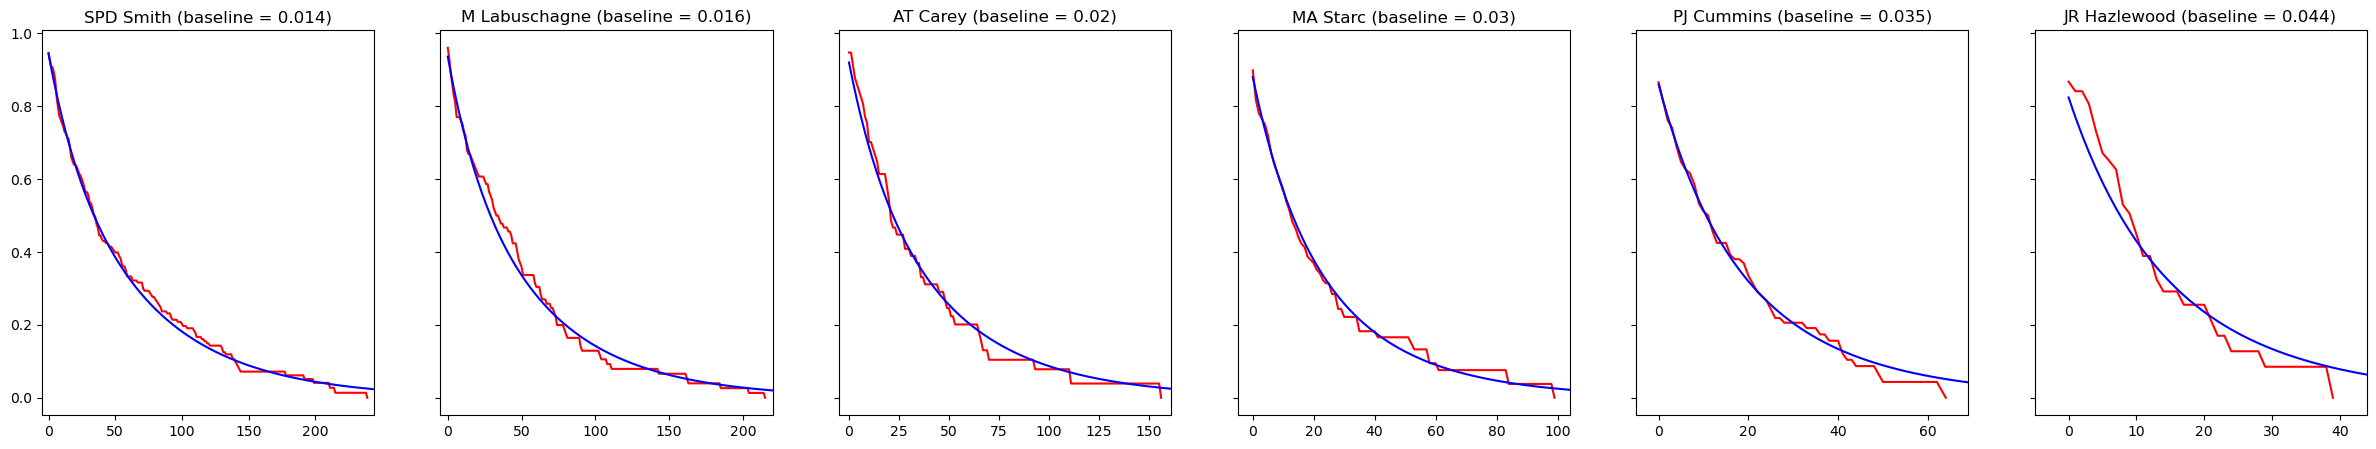

In [19]:
batters = ["SPD Smith", "M Labuschagne", "AT Carey", "MA Starc", "PJ Cummins", "JR Hazlewood"]
fig, ax = plt.subplots(1, len(batters), figsize=(5*len(batters), 5), sharey=True)
for i, batter in zip(range(len(batters)), batters):
    observed_survival = (1 - get_hazard(batter)).cumprod()
    ax[i].plot(observed_survival, color="red")
    baseline = get_baseline(batter).sort_values(by="sq_err")["baseline"].iloc[0]
    inferred_hazard = get_hazard_given_baseline(baseline)
    inferred_survival = (1 - inferred_hazard).cumprod()
    ax[i].plot(inferred_survival, color="blue")
    ax[i].set_title(f"{batter} (baseline = {baseline})")
    ax[i].set_xlim(-5, max(observed_survival.index) + 5)
plt.show()

This curve is sometimes a poor fit for bowlers, but this is about looking at players who don't have batting at their short suit - a good fit on players who aren't specialist bowlers is much more improtant. And luckily batters tend to have survival curves of almost the exact same shape, as can be seen by picking a number of batters who have about the same area under their survival curve: 

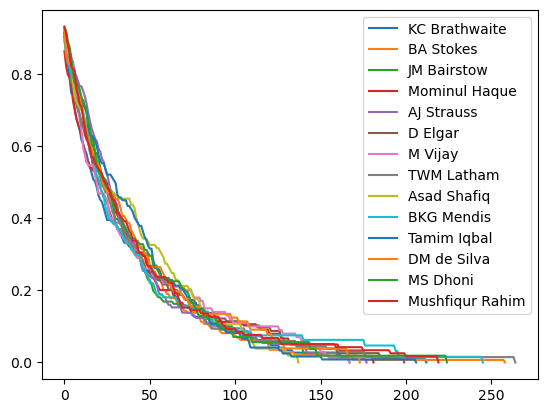

In [20]:
names = batter_areas.sort_values().iloc[800:880].index.to_list()
name_series = pd.Series([len(outs[name]) for name in names], index=names)
trim_names = name_series[name_series > 100].index
graph_survival_odds(trim_names)

This estimated baseline hazard number is somewhat harder to interpret than more widely used numbers, like batting average. However, there are two ways that it can become a bit more intuitive. 

First, baseline hazard is the probability that, after a batter has got their eye in, they get out before they get their next run. So once Steve Smith is on 140 or so, he has a 1.4% probability of getting out on his current score, whereas Mitchell Starc has a 3% probability. (I don't use Hazlewood to illustrate this point because it's a bit too hard to imagine him reaching 140.) This might seem a bit puzzling, because it looks like these numbers imply that Smith's batting average should be about triple Hazlewood's, when it's actually closer to five times, but this is because the hazard decreases as one gets more runs. If Smith and Hazlewood are on the same number of runs, Hazlewood is 3x likelier to get out before getting another run than Smith, but Smith tends to get more runs, so Hazlewood's average hazard at the crease is more than 3x Smith's. 

Second, baseline hazard can be converted into a number much like a batting average (using the method in the next cell). This gives a number quite close to a batter's average, but not exactly their average. Rather, this number is a (non-Bayesian) estimate of expected runs were you to make them bat until they got out, i.e., they won't run out of overs, won't declare, won't chase the other side's total, etc.

In [21]:
def get_exp_runs_from_baseline(baseline):
    ser = pd.Series(np.arange(1000))
    hazard = get_hazard_given_baseline(baseline)
    int_hazard = (1 - hazard).cumprod()
    return int_hazard.sum()

# Getting priors

Start by getting the best estimate of each batter's baseline hazard. This takes about 15s to run, so be patient.

In [22]:
# Get all batters with >=20 dismissals
relevant_batters = [key for key in outs.keys() if len(outs[key]) >= 20]
baselines = []
for batter in relevant_batters:
    baselines.append(get_baseline(batter).sort_values(by="sq_err")["baseline"].iloc[0])
baseline_series = pd.Series(baselines, index=relevant_batters)

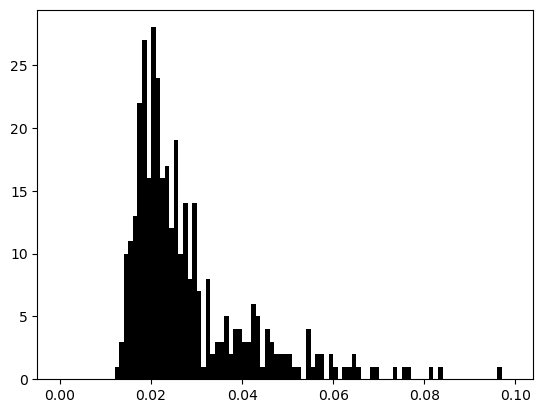

In [23]:
fig, ax = plt.subplots()
bins = np.arange(0, 0.1, 0.001)
ax.hist(baseline_series, bins=bins, color="black")
plt.show()

The histogram of batters' estimated baseline hazard looks like a strange distribution. This is because there really are two populations in here: specialist batters (the big peak on the left) and specialist bowlers (the flatter lump on the right). I ignore all-rounders because they are good enough at batting that they can't be separated from the specialist batters: the best all-rounders are much better at batting than the worst specialist batters. In fact, almost all of the players who have an estimated baseline hazard larger than 0.35 are bowlers: 

In [24]:
baseline_series[baseline_series >= 0.035].sample(10)

S Sreesanth          0.050
RAS Lakmal           0.047
Mohammad Asif        0.076
A Kumble             0.036
CBRLS Kumara         0.068
UWMBCA Welegedara    0.057
JE Taylor            0.048
PJ Cummins           0.035
Saeed Ajmal          0.046
NGRP Jayasuriya      0.064
dtype: float64

And a good fit for the non-bowler part of the distribution is a log-normal distribution: 

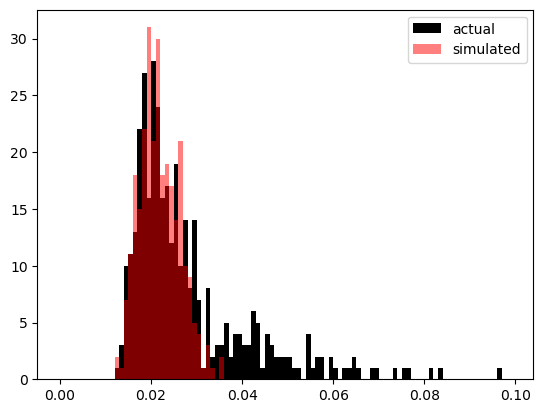

In [25]:
fig, ax = plt.subplots()
bins = np.arange(0, 0.1, 0.001)
ax.hist(baseline_series, bins=bins, color="black")
simulated_data = np.random.normal(-3.84, 0.22, 282)
ax.hist(np.exp(simulated_data), bins=bins, color="red", alpha=0.5)
ax.legend(["actual", "simulated"])
plt.show()

So I will go with this as the prior. 

In [26]:
def get_prior():
    mean = -3.84
    stdev = 0.22
    index = np.round(np.arange(0, 0.25, 0.001), decimals=3)
    term_a = (1 / (index * stdev * (2 * np.pi) ** 0.5)) 
    term_b = np.exp((-(np.log(index) - mean) ** 2) / (2 * stdev ** 2))
    prior = pd.Series(term_a * term_b, index=index)
    prior.iloc[0] = 0
    return prior

# Getting likelihoods

The probability of a batter with baseline hazard x getting out on N is the probability of them surviving 0, 1, ..., N-1 and not surviving N. Here is how likely getting N is on a range of baseline hazards (the minimum possible is 0, which is never getting out, and the maximum possible is 0.25, which is never getting a run, noting that when a batter hasn't yet got a run the hazard rate is 4 times baseline). Ignore the y-axis, that will be normalised later; what matters is the shape of these likelihood curves. 

(The following cell takes under a minute to run: each generate_out_likelihood query takes a little while, so I generate all those less than 200 and save them in a dictionary to save time later.)

In [27]:
def generate_out_likelihood(score):
    """
    Put in a score that a given player got out on
    Get back a series, index is baseline, value is likelihood of getting out on X
    given their survival baseline is the index
    """
    def get_likelihood_out_given_baseline(score, baseline):
        """
        Input score and baseline
        Get back probability of getting out on that score, given baseline
        """
        hazard = get_hazard_given_baseline(baseline)
        # Prob you get out on exactly n: prob you survive 0, 1, ..., n-1, and die on n
        if score == 0:
            return hazard.iloc[0]
        else:
            return (1 - hazard).iloc[:score].prod() - (1 - hazard).iloc[:score + 1].prod()

    index = np.round(np.arange(0, 0.25, 0.001), decimals=3)
    values = [get_likelihood_out_given_baseline(score, i) for i in index]
    return pd.Series(values, index=index)

out_likelihoods = {i: generate_out_likelihood(i) for i in range(200)}
def get_likelihood_out(score):
    if score < 200:
        return out_likelihoods[score]
    else:
        return generate_out_likelihood(score)

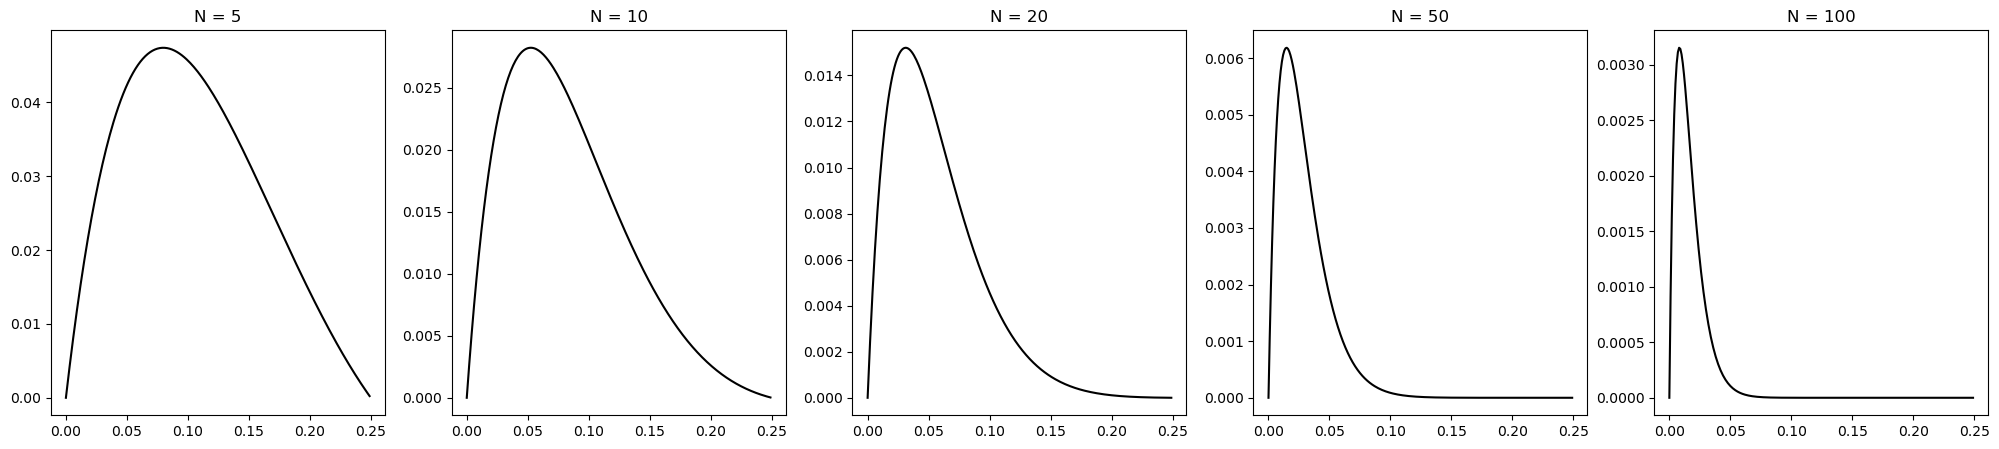

In [28]:
out_on = [5, 10, 20, 50, 100]
fig, ax = plt.subplots(1, len(out_on), figsize=(5*len(out_on), 5))
for i, n in zip(range(len(out_on)), out_on):
    ax[i].plot(get_likelihood_out(n), color="black")
    ax[i].set_title(f"N = {n}")
plt.show()

The probability of a batter with baseline hazard x getting to N not out is the probability that they survive 0, 1, ..., N-1. The likelihoods look as follows: 

In [29]:
def generate_likelihood_not_out(score):
    """
    Put in a score that a given player got not-out on
    Get back a series, index is baseline, value is likelihood of getting to X
    before getting out
    """
    def get_likelihood_not_out_given_baseline(score, baseline):
        """
        Input score and baseline
        Get back prob of getting to that score before getting out
        i.e., prob of not getting out before getting to that score
        """
        if score == 0:
            return 1
        hazard = get_hazard_given_baseline(baseline)
        return (1 - hazard).iloc[:score].prod()

    index = np.round(np.arange(0, 0.25, 0.001), decimals=3)
    values = [get_likelihood_not_out_given_baseline(score, i) for i in index]
    return pd.Series(values, index=index)

not_out_likelihoods = {i: generate_likelihood_not_out(i) for i in range(200)}
def get_likelihood_not_out(score):
    if score < 200:
        return not_out_likelihoods[score]
    else:
        return generate_likelihood_not_out(score)

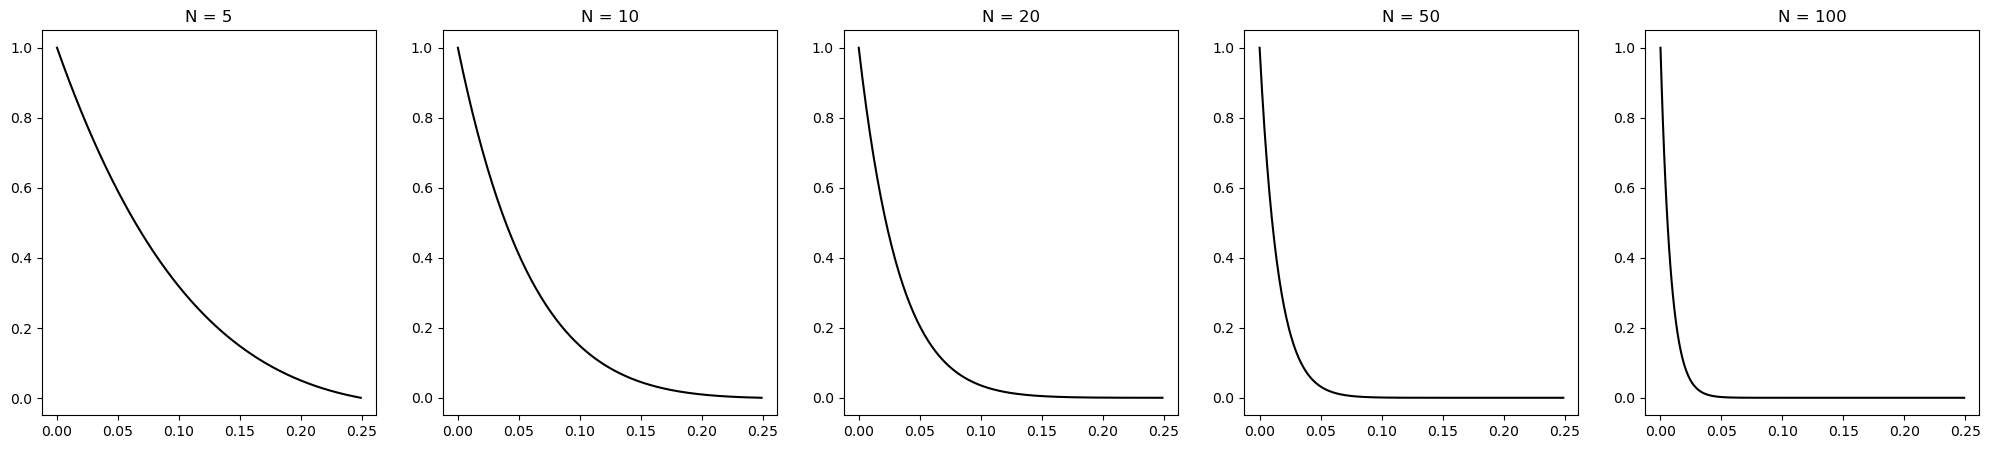

In [30]:
not_out_on = [5, 10, 20, 50, 100]
fig, ax = plt.subplots(1, len(not_out_on), figsize=(5*len(not_out_on), 5))
for i, n in zip(range(len(not_out_on)), not_out_on):
    ax[i].plot(get_likelihood_not_out(n), color="black")
    ax[i].set_title(f"N = {n}")
plt.show()

# Conclusions

That is everything needed to figure out how good Kurtis Patterson REALLY is. Or rather, what you can make of his two Test innings. 

In [31]:
def get_posterior_for_batter(batter):
    # Make the dataframe
    batter_df = pd.DataFrame({"prior": get_prior()})
    out_scores = outs[batter]
    not_out_scores = not_outs[batter]
    for out_score, i in zip(out_scores, range(len(out_scores))):
        batter_df[f"out_update_{i}"] = get_likelihood_out(out_score)
    for not_out_score, i in zip(not_out_scores, range(len(not_out_scores))):
        batter_df[f"not_out_update{i}"] = get_likelihood_not_out(not_out_score)
    
    # Get posterior
    horiz_prod = np.log(batter_df).sum(axis=1)
    horiz_prod -= horiz_prod.max() # This stops them all being 0 when you exp
    redone_avg = np.exp(horiz_prod)
    
    # Adjust posterior so is integral is 1
    increment = redone_avg.index[1] - redone_avg.index[0]
    area_under_curve = increment * redone_avg.sum()
    posterior_dist = redone_avg / area_under_curve
    return posterior_dist

def graph_posterior_versus_prior(posterior):
    fig, ax = plt.subplots()
    ax.plot(get_prior(), color="blue")
    ax.plot(posterior, color="red")
    ax.legend(["prior", "posterior"])
    ax.set_xlim(0, 0.08)
    plt.show()

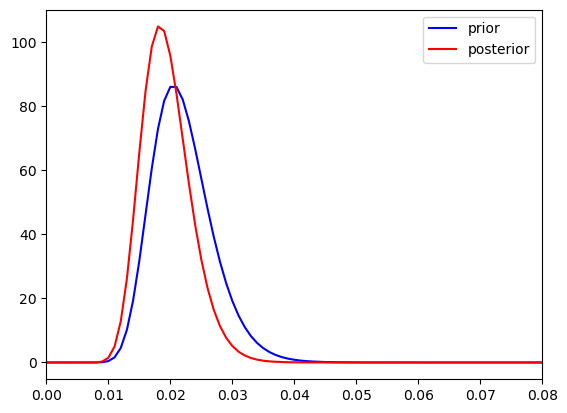

In [32]:
patterson_posterior = get_posterior_for_batter("KR Patterson")
graph_posterior_versus_prior(patterson_posterior)

So his two Test scores give us reason to suppose that Patterson's baseline hazard is lower than before we had any information. But the mean has not moved that much, and the width of the distribution shows there is quite a lot of uncertainty. Quantifying the movement in the mean: 

In [33]:
def print_info_for_posterior(posterior):
    mean = (posterior * posterior.index).sum() * 0.001
    return f"mean: {mean:.4f}, with expected runs {get_exp_runs_from_baseline(mean):.2f}"

print(f"Prior {print_info_for_posterior(get_prior())}")
print(f"Posterior {print_info_for_posterior(patterson_posterior)}")

Prior mean: 0.0220, with expected runs 33.47
Posterior mean: 0.0194, with expected runs 38.94


So you should suppose he is better than your average batter, but you probably shouldn't expect him to get 144 before his next wicket. And compare this to a good batter with a somewhat lower average, but who has consistently performed well, like Steve Smith:

Smith posterior mean: 0.0145, with expected runs 54.91


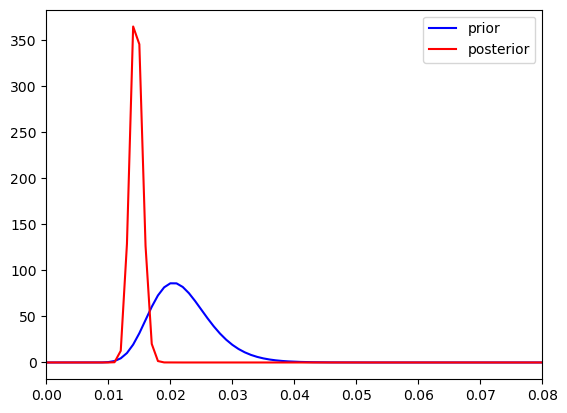

In [34]:
smith_posterior = get_posterior_for_batter("SPD Smith")
print(f"Smith posterior {print_info_for_posterior(smith_posterior)}")
graph_posterior_versus_prior(smith_posterior)

Now to answer some more general questions about how much information extreme scores for the first few innings of a batter's Test career can tell you. 

In [35]:
def get_info_for_hypothetical_batter(batter_outs, batter_not_outs):
    batter = "Hypothetical"
    outs[batter] = batter_outs
    not_outs[batter] = batter_not_outs
    
    posterior = get_posterior_for_batter(batter)
    print(f"Prior {print_info_for_posterior(get_prior())}")
    print(f"Posterior {print_info_for_posterior(posterior)}")
    graph_posterior_versus_prior(posterior)
    
    del outs[batter]
    del not_outs[batter]

Prior mean: 0.0220, with expected runs 33.47
Posterior mean: 0.0243, with expected runs 29.76


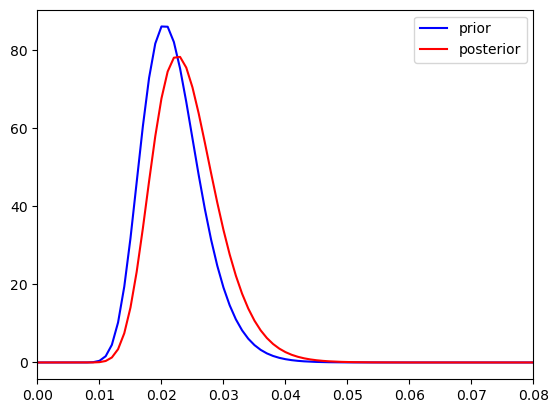

In [38]:
# Change these next three lines as you wish to see how a hypothetical batter stacks up
batter_outs = [0, 0]
batter_not_outs = []

get_info_for_hypothetical_batter(batter_outs, batter_not_outs)

DA Warner posterior mean: 0.0170, with expected runs 45.57


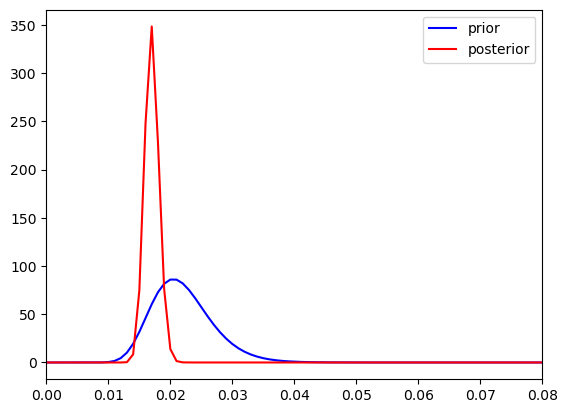

In [332]:
# Change this cell to see how an actual batter's stats look 
# (use the following one to look up players)
# NOTE: this uses the non-bowler prior, so will give overestimates
# of how good specialist bowlers are at batting
batter = "DA Warner"

batter_posterior = get_posterior_for_batter(batter)
print(f"{batter} posterior {print_info_for_posterior(batter_posterior)}")
graph_posterior_versus_prior(batter_posterior)

In [331]:
# Name finder utility
component = "Warner"
for name in batter_names:
    if component in name:
        print(name)

DA Warner


Some interesting conclusions:
* The above algorithm is a little unfair to Patterson, because it treats his 114* equally to if he had not got out. Being very generous and assuming that he would have doubled his score before getting out on 228, still his expected runs are 41.3, far below the top tier of batters.
* A promising young batter gets a pair of ducks on debut. This doesn't give you much new information at all: their expected runs only drops from 33.5 to 29.8.
* Ten ducks in a row, however, is quite a bad start to a career: expected runs drops from 34.3 to 18.4. Still, it's quite remarkable that after getting ten ducks in a row, you still expect that, were they to play until they got out, they would get 18 runs, rather than something like 2 or 3 which might seem more plausible.
* A pair of centuries will likely have the press going bonkers, but even that dramatic start only suggests that their expected runs is 39.4, rather than the 60+ which many people would expect.
* To have one's expected runs (or equivalently, their estimated baseline hazard) be better than Steve Smith's after only one innings, one must score 621 runs. Alternatively, for a batter's expected runs/estimated baseline hazard to exceed Steve Smith's, they need to score 11 centuries in a row. 